# LNG Price Recoupling and Energy Pool

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

## Net Exporter

In [3]:
imp_exp = pd.read_csv('data/natgas-imports-exports-netimports.csv', skiprows = 6,
                     names = ['Year', 'Imports', 'Exports'])

imp_exp['Net Export'] =  imp_exp['Exports'] - imp_exp['Imports']

imp_exp.head()

,Year,Imports,Exports,Net Export
0,1950,0.00,0.03,0.03
1,1951,0.00,0.02,0.02
2,1952,0.01,0.03,0.02
3,1953,0.01,0.03,0.02
4,1954,0.01,0.03,0.02


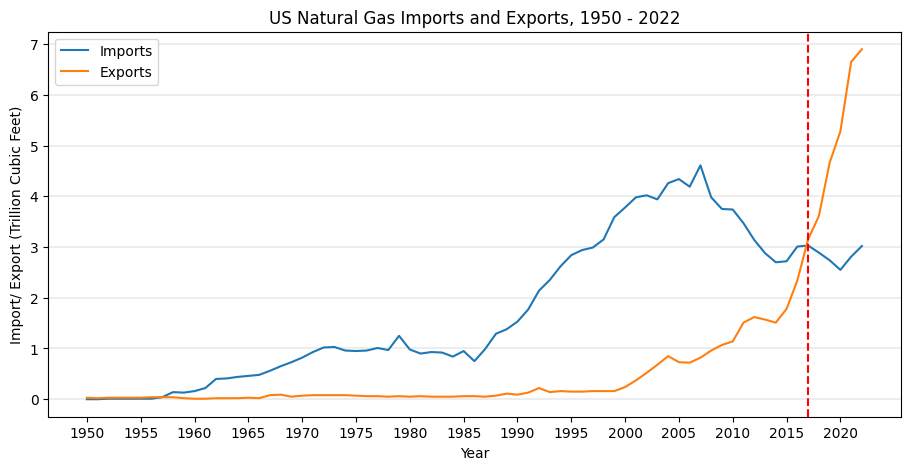

In [4]:
imp_exp.plot('Year', ['Imports', 'Exports'],
             title = 'US Natural Gas Imports and Exports, 1950 - 2022',
             ylabel = 'Import/ Export (Trillion Cubic Feet)',
            figsize = (11,5))
plt.xticks(np.arange(1950, 2022, 5))
plt.grid(axis='y', color='gray', linewidth=0.2)
plt.axvline(x=2017, color='red', linestyle = '--');

In [5]:
#show that US changed to net exporter in 2017
imp_exp[imp_exp["Year"].isin([2016, 2017])][['Year', 'Net Export']]

,Year,Net Export
66,2016,-0.67
67,2017,0.12


<Axes: xlabel='Year'>

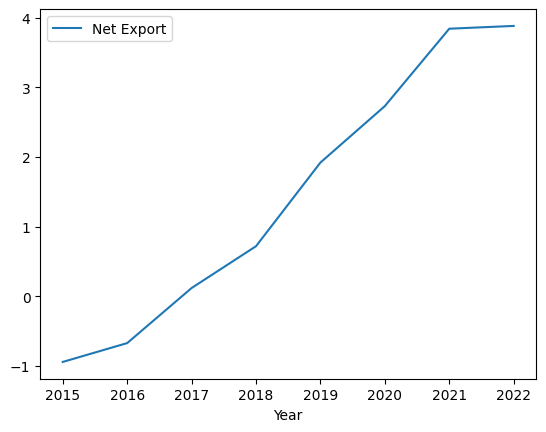

In [6]:
imp_exp[imp_exp["Year"] >= 2015].plot('Year', 'Net Export')

## Prices

In [7]:
#Henry Hub start Jan 1997
henry_hub = pd.read_csv('data/Henry_Hub_Natural_Gas_Spot_Price.csv',
                       skiprows = 5, names = ['Date', 'Henry Hub Price'])

henry_hub['Date'] = pd.to_datetime(henry_hub['Date'], format='%b %Y')

henry_hub.tail()

,Date,Henry Hub Price
328,1997-05-01,2.25
329,1997-04-01,2.03
330,1997-03-01,1.89
331,1997-02-01,2.15
332,1997-01-01,3.45


In [8]:
# Oil WTI prices starting Jan 1986
wti = pd.read_csv('data/Cushing_OK_WTI_Spot_Price_FOB.csv',
                  skiprows = 5, names = ['Date', 'WTI Price'])

wti['Date'] = pd.to_datetime(wti['Date'], format='%b %Y')

wti.tail()

,Date,WTI Price
461,1986-05-01,15.38
462,1986-04-01,12.84
463,1986-03-01,12.61
464,1986-02-01,15.46
465,1986-01-01,22.93


WTI energy parity = 0.172

WTI NGCC parity = 0.127 (-4 for LTR)

(Cite paper)

In [9]:
wti['WTI Energy Parity Price'] = wti['WTI Price'] * 0.172

wti['WTI NGCC Parity Price'] = wti['WTI Price'] * 0.127 - 4

#NGCC Parity only applies after 2016
wti.loc[wti['Date'] < '2016-01-01', 'WTI NGCC Parity Price'] = pd.NA

wti.tail()

,Date,WTI Price,WTI Energy Parity Price,WTI NGCC Parity Price
461,1986-05-01,15.38,2.64536,NaN
462,1986-04-01,12.84,2.20848,NaN
463,1986-03-01,12.61,2.16892,NaN
464,1986-02-01,15.46,2.65912,NaN
465,1986-01-01,22.93,3.94396,NaN


In [10]:
prices = henry_hub.merge(wti, on = "Date", how = "left")

prices.drop('WTI Price', axis = 1, inplace = True)

prices

,Date,Henry Hub Price,WTI Energy Parity Price,WTI NGCC Parity Price
0,2024-09-01,2.28,12.08128,4.92048
1,2024-08-01,1.99,13.18896,5.73836
2,2024-07-01,2.07,14.06960,6.38860
3,2024-06-01,2.54,13.72044,6.13079
4,2024-05-01,2.12,13.76344,6.16254
...,...,...,...,...
328,1997-05-01,2.25,3.58104,NaN
329,1997-04-01,2.03,3.38840,NaN
330,1997-03-01,1.89,3.60684,NaN
331,1997-02-01,2.15,3.81496,NaN


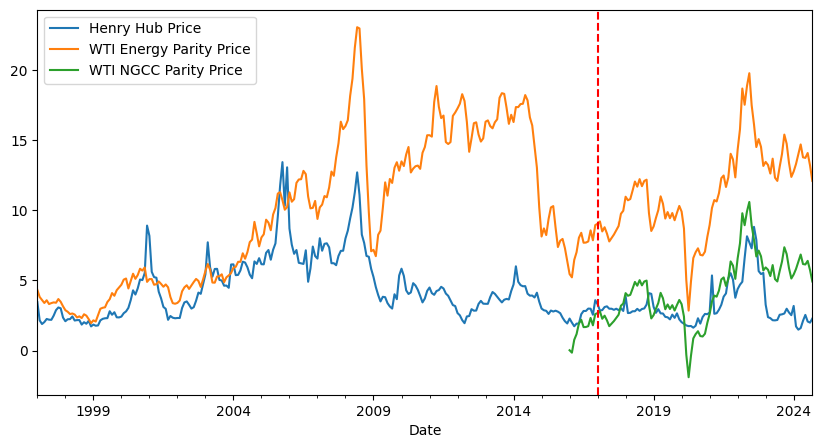

In [11]:
prices.plot('Date', ['Henry Hub Price', 'WTI Energy Parity Price', 'WTI NGCC Parity Price'],
             figsize = (10,5))
plt.axvline(x='2017-01-01', color='red', linestyle = '--')
             

### Yearly Covariance and Correlation Between the Prices

In [32]:
prices['Year'] = prices['Date'].dt.year

yearly_cov = prices.groupby('Year').apply(
    lambda x: pd.Series({
        'Energy Parity Covariance': x['Henry Hub Price'].cov(x['WTI Energy Parity Price']),
        'NGCC Parity Covariance': x['Henry Hub Price'].cov(x['WTI NGCC Parity Price']),
        'Energy Parity Correlation': x['Henry Hub Price'].corr(x['WTI Energy Parity Price']),
        'NGCC Parity Correlation': x['Henry Hub Price'].corr(x['WTI NGCC Parity Price'])
    })
    )

yearly_cov = yearly_cov.reset_index()

yearly_cov.tail()

/var/folders/pb/cpqxrzd16p329rb899j1pskw0000gn/T/ipykernel_825/269641353.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_cov = prices.groupby('Year').apply(


,Year,Energy Parity Covariance,NGCC Parity Covariance,Energy Parity Correlation,NGCC Parity Correlation
23,2020,0.259938,0.191931,0.405409,0.405409
24,2021,0.938528,0.692983,0.581716,0.581716
25,2022,1.255396,0.926949,0.394568,0.394568
26,2023,0.168485,0.124404,0.498739,0.498739
27,2024,-0.218023,-0.160982,-0.541530,-0.541530


Text(0.5, 1.0, 'Yearly Covariance between Henry Hub and WTI Prices')

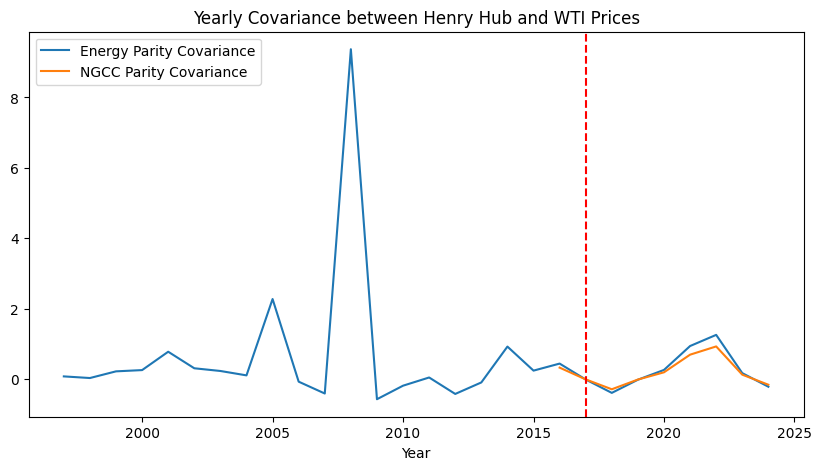

In [37]:
yearly_cov.plot('Year', 
            ['Energy Parity Covariance', 'NGCC Parity Covariance'],
             figsize = (10,5))
plt.axvline(x= 2017, color='red', linestyle = '--')
plt.title('Yearly Covariance between Henry Hub and WTI Prices')


Text(0.5, 1.0, 'Yearly Correlation between Henry Hub and WTI Prices')

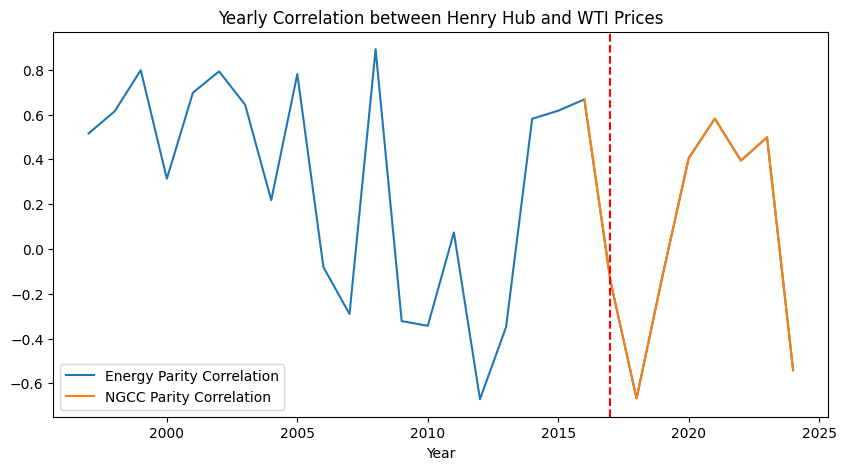

In [38]:
yearly_cov.plot('Year', 
            ['Energy Parity Correlation', 'NGCC Parity Correlation'],
             figsize = (10,5))
plt.axvline(x= 2017, color='red', linestyle = '--')
plt.title('Yearly Correlation between Henry Hub and WTI Prices')

### Difference of Marginal Change of Prices

In [ ]:
prices['Henry Hub Marginal Change'] = prices['Henry Hub Price'].diff()
prices['WTI Energy Parity Marginal Change'] = prices['WTI Energy Parity Price'].diff()
prices['WTI NGCC Parity Marginal Change'] = prices['WTI NGCC Parity Price'].diff()

prices.head()

,Date,Henry Hub Price,WTI Energy Parity Price,WTI NGCC Parity Price,Energy Parity Correlation,NGCC Parity Correlation,Henry Hub Marginal Change,WTI Energy Parity Marginal Change,WTI NGCC Parity Marginal Change
0,2024-09-01,2.28,12.08128,4.92048,NaN,NaN,NaN,NaN,NaN
1,2024-08-01,1.99,13.18896,5.73836,NaN,NaN,-0.29,1.10768,0.81788
2,2024-07-01,2.07,14.06960,6.38860,-0.746432,-0.746432,0.08,0.88064,0.65024
3,2024-06-01,2.54,13.72044,6.13079,0.251264,0.251264,0.47,-0.34916,-0.25781
4,2024-05-01,2.12,13.76344,6.16254,-0.669671,-0.669671,-0.42,0.04300,0.03175


<Axes: xlabel='Date'>

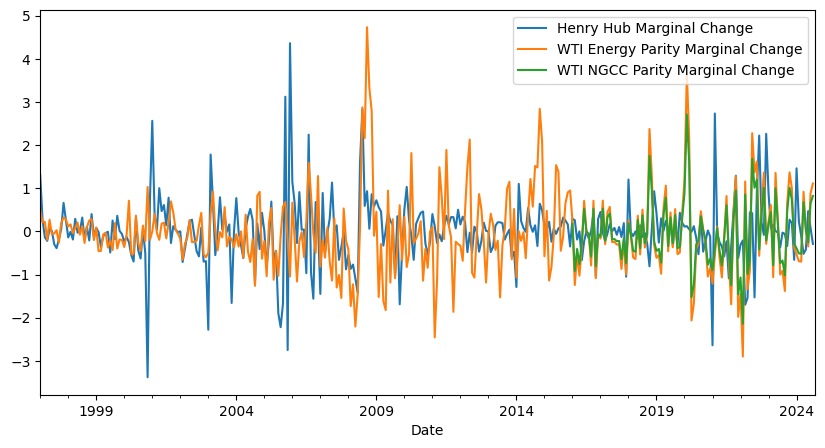

In [ ]:
prices.plot('Date', 
            ['Henry Hub Marginal Change', 'WTI Energy Parity Marginal Change', 'WTI NGCC Parity Marginal Change'],
             figsize = (10,5))

In [ ]:
prices['Energy Parity Difference'] = abs(prices['WTI Energy Parity Marginal Change'] - prices['Henry Hub Marginal Change'])
prices['NGCC Parity Difference'] = abs(prices['WTI NGCC Parity Marginal Change'] - prices['Henry Hub Marginal Change'])

prices.loc[prices['Date'] < '2016-01-01', 'WTI NGCC Parity Marginal Change'] = pd.NA
prices.loc[prices['Date'] < '2016-01-01', 'NGCC Parity Difference'] = pd.NA

prices.tail()

,Date,Henry Hub Price,WTI Energy Parity Price,WTI NGCC Parity Price,Energy Parity Correlation,NGCC Parity Correlation,Henry Hub Marginal Change,WTI Energy Parity Marginal Change,WTI NGCC Parity Marginal Change,Energy Parity Difference,NGCC Parity Difference
328,1997-05-01,2.25,3.58104,NaN,0.918871,NaN,0.05,0.26832,NaN,0.21832,NaN
329,1997-04-01,2.03,3.38840,NaN,0.448474,NaN,-0.22,-0.19264,NaN,0.02736,NaN
330,1997-03-01,1.89,3.60684,NaN,0.019321,NaN,-0.14,0.21844,NaN,0.35844,NaN
331,1997-02-01,2.15,3.81496,NaN,0.448645,NaN,0.26,0.20812,NaN,0.05188,NaN
332,1997-01-01,3.45,4.32236,NaN,0.991501,NaN,1.30,0.50740,NaN,0.79260,NaN


<Axes: xlabel='Date'>

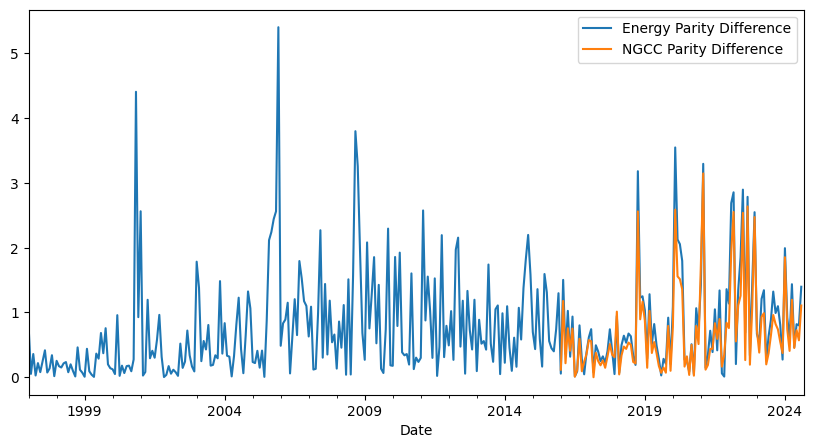

In [ ]:
prices.plot('Date', 
            ['Energy Parity Difference', 'NGCC Parity Difference'],
             figsize = (10,5))